In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# data.head()

def write(clf,dataset):
    test = pd.read_csv('test.csv')
    op = np.exp(clf.predict(dataset))
    op = pd.DataFrame(data = (test['Id'],op),index=None)
    op = op.T
    op.columns = ['Id','SalePrice']
    op.to_csv(r'Submission.csv',index=False)


## Understanding Data

1. Plot a correlation heatmap

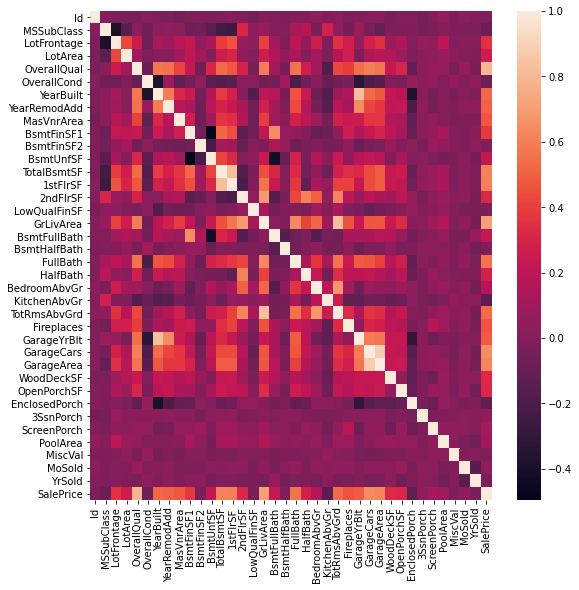

In [2]:
corr = data.corr()
plt.figure(figsize=(9,9))
sns.heatmap(corr)


We can now use this plot to understand following things :<br>
    1. How SalesPrice column relates with other features ? <br>
    2. How other features are related with each other ?

Beyond the diagonal line, we can see these two white spots : TotalBsmtSF Vs 1st Flr SF and Garage Variables showing how these two variables have strong correlation (implying a possible case of multicollinearity)
<h3> <b>MultiCollinearity </b><br></h3>
    Multicollinearity occurs when independent variables in a regression model are correlated. This correlation is a problem because independent variables should be independent. If the degree of correlation between variables is high enough, it can cause problems when you fit the model and interpret the results

To answer question 1 , lets take a more clear look into sales correlations : 

## Sales correlations

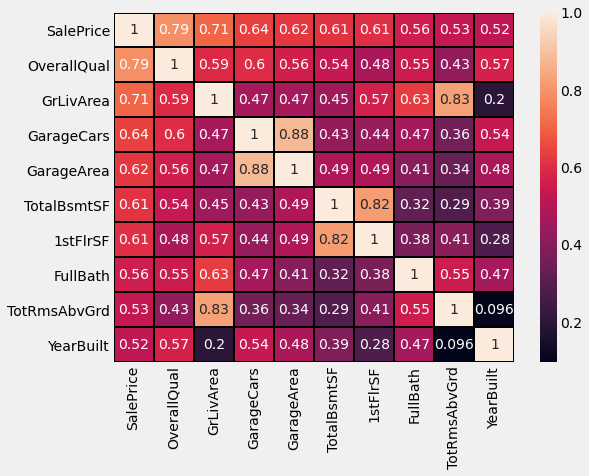

In [3]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))

largest_corr = corr.nlargest(10,'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[largest_corr].values.T)
sns.heatmap(cm,annot = True,linewidths = 1, linecolor = 'black',yticklabels=largest_corr.values, xticklabels=largest_corr.values)

# sns.heatmap(corr,annot=True,linewidths=1,linecolor='black',)



Conclusions from this : <br>

    1) GarageCars and area are similar. So we can go with only one of the feature.<br>
    2) Same with total BSMTSF and 1stflrSF  and also GrLiveArea/TotRmsAbvGrd.<br>
    


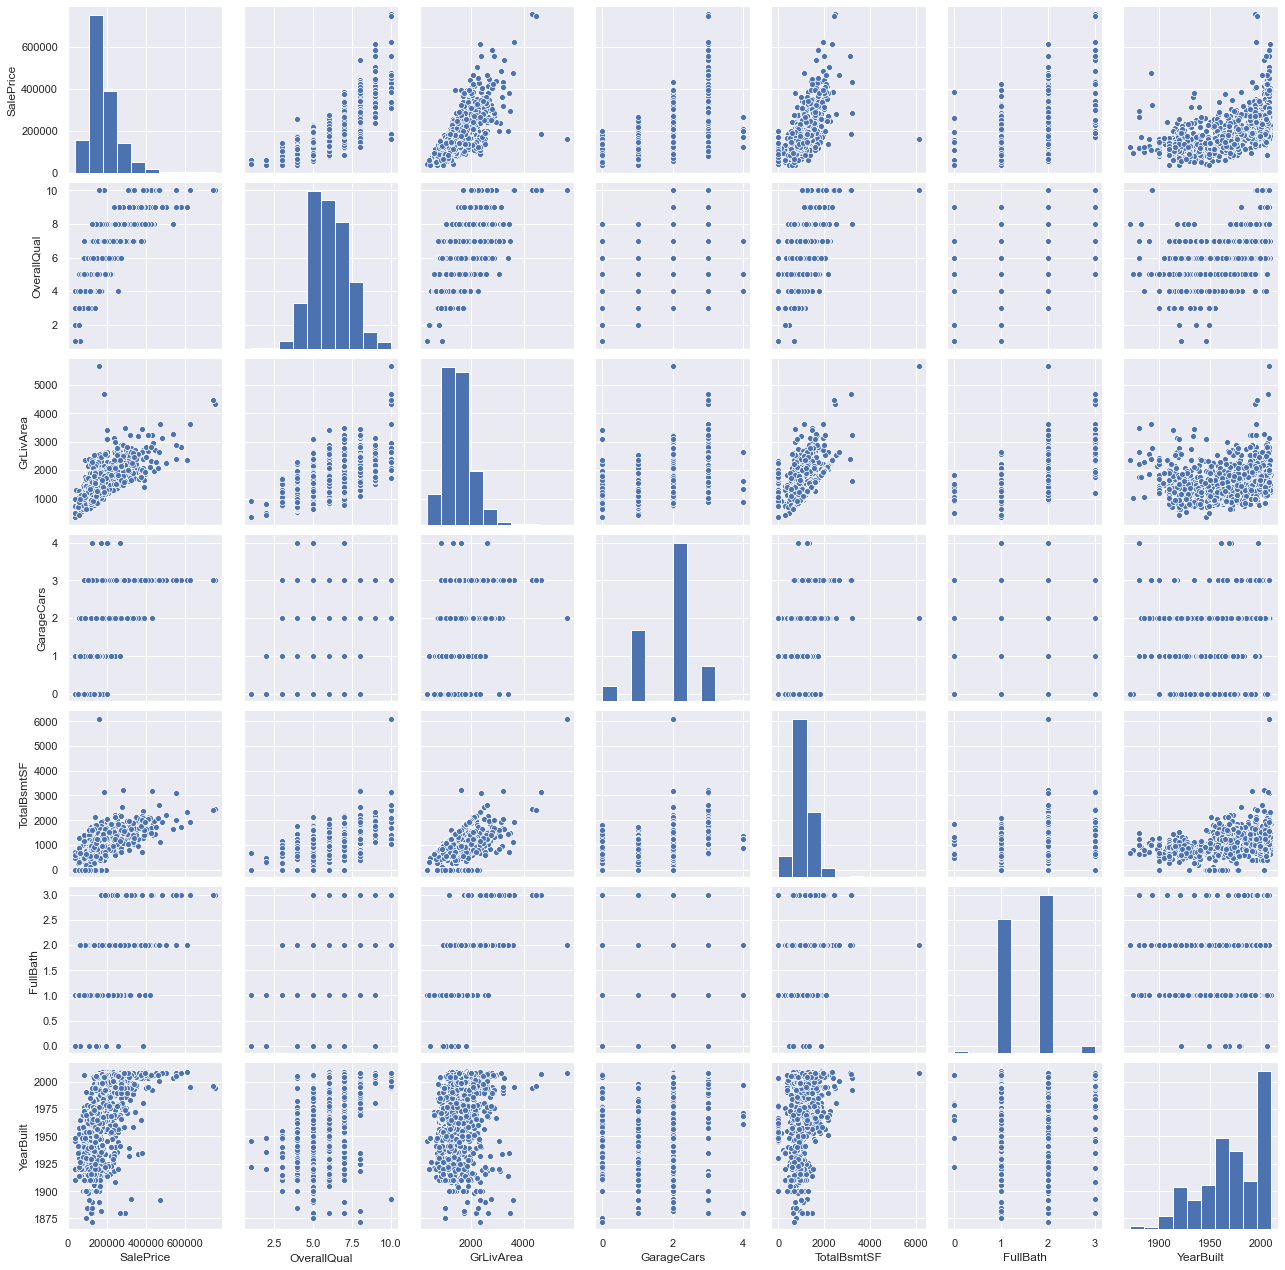

In [4]:
# sorted(data.columns)
sns.set()
col_list = ['SalePrice','OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt']
sns.pairplot(data[col_list])



# Missing data

In [5]:
x = pd.DataFrame((data.isnull().sum()/data.shape[0])*100,columns=['Value'])
x['cnts'] = data.isnull().sum()
x.sort_values(by='Value',ascending=False).head(14)

,Value,cnts
PoolQC,99.520548,1453
MiscFeature,96.301370,1406
Alley,93.767123,1369
Fence,80.753425,1179
FireplaceQu,47.260274,690
LotFrontage,17.739726,259
GarageYrBlt,5.547945,81
GarageCond,5.547945,81
GarageType,5.547945,81
GarageFinish,5.547945,81


1. Drop all of the featuers with missing values > 15%.
2. GarageX and BsmtX variables arre already accounted for. So we can drop these too.
3. MasVnrX are highly correlated with Yr variables.
4. Since electrical has only 1 null value lets droop it.


In [6]:
d2 = data.copy()
d2 = d2.drop((x[x.cnts >1]).index,axis=1)
d2 = d2.drop(columns='Electrical',axis=1)

# Outlier Handling

1. Identify outlier values in features that play great role in sale price

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


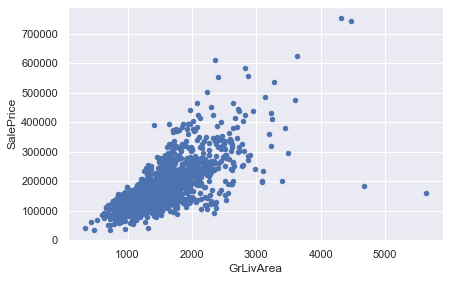

In [7]:
d2.plot.scatter(x='GrLivArea',y='SalePrice')

As we can see, there are two GrLivArea values that seem to be outliers. So lets drop them


In [8]:
(d2.sort_values(by='GrLivArea',ascending=False))[['Id','GrLivArea']]
# d2[d2.index==5642]
d2 = d2.drop((d2[(d2.Id==1299)|(d2.Id ==524)]).index)

Similar analysis can bbe done with Bsmt.

## Now we need to understand what is Sales Price statistically.
For this we can do 4 of these tests :<br>
1) Normality <br>
2) Linearity <br>
3) Homoscedasticity <br>
4) Absence of correlated errors
<br><br>
For details : https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

### Normality

Histogram <br>
Normal probability plot

Text(0.5, 1.0, 'Prob Plot')

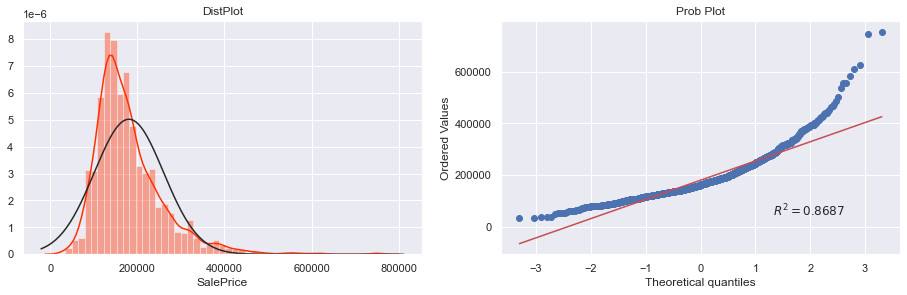

In [9]:
from scipy.stats import norm
from scipy import stats


plt.style.use('seaborn-pastel')
sns.set_palette('jet_r')
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(d2['SalePrice'], fit=norm);
plt.title('DistPlot')

plt.subplot(122)
stats.probplot(d2['SalePrice'], plot=plt,rvalue=True)
plt.title('Prob Plot')


To understand this probplot : https://dfrieds.com/math/probability-plot.html


From 1 and 2 its clear that its not exactly normal but skewed,peaked and doesn't follow the st normal line.

In case of positive skewness as in this, <b>log transformation </b>works very nicely.

Text(0.5, 1.0, 'Prob Plot')

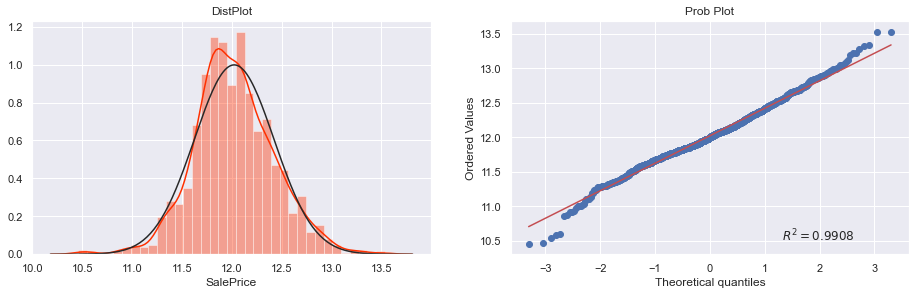

In [10]:
df = d2.copy()
df['SalePrice'] = np.log(df.SalePrice)

# plt.style.use('seaborn-pastel')
# sns.set_palette('jet_r')

plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(df['SalePrice'], fit=norm);
plt.title('DistPlot')

plt.subplot(122)
stats.probplot(df['SalePrice'], plot=plt,rvalue=True)
plt.title('Prob Plot')


Text(0.5, 1.0, 'Prob Plot')

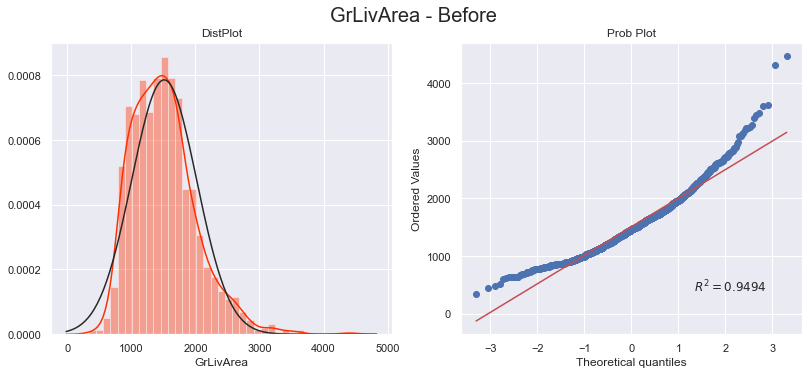

In [11]:
plt.figure(figsize=(12,5))
plt.suptitle('GrLivArea - Before', fontsize=20)

plt.subplot(121)
sns.distplot(df['GrLivArea'], fit=norm);
plt.title('DistPlot')

plt.subplot(122)
stats.probplot(df['GrLivArea'], plot=plt,rvalue=True)
plt.title('Prob Plot')



Text(0.5, 1.0, 'Prob Plot')

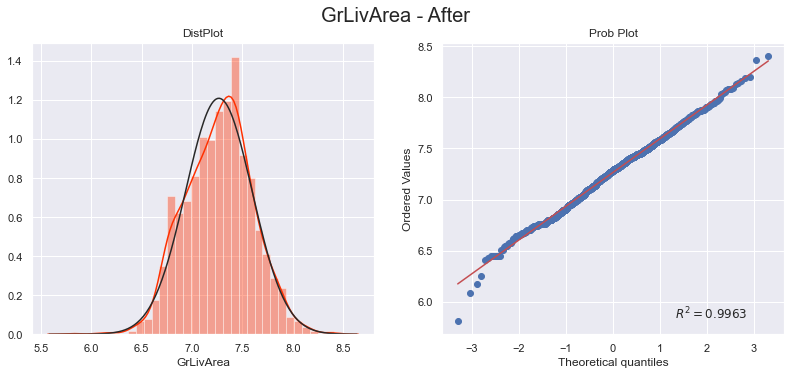

In [12]:
df['GrLivArea'] = np.log(df.GrLivArea)

plt.figure(figsize=(12,5))
plt.suptitle('GrLivArea - After', fontsize=20)

plt.subplot(121)
sns.distplot(df['GrLivArea'], fit=norm);
plt.title('DistPlot')

plt.subplot(122)
stats.probplot(df['GrLivArea'], plot=plt,rvalue=True)
plt.title('Prob Plot')



Text(0.5, 1.0, 'Prob Plot')

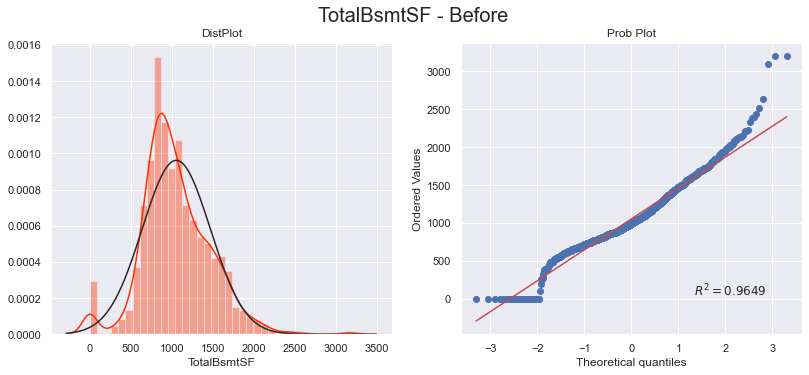

In [13]:
plt.figure(figsize=(12,5))
plt.suptitle('TotalBsmtSF - Before', fontsize=20)

plt.subplot(121)
sns.distplot(df['TotalBsmtSF'], fit=norm);
plt.title('DistPlot')

plt.subplot(122)
stats.probplot(df['TotalBsmtSF'], plot=plt,rvalue=True)
plt.title('Prob Plot')



The 0 values would hamper log ttransformation as log(0) is undefined.

In [14]:
df['TotalBsmtSF'] = df['TotalBsmtSF'].apply(lambda x : np.log(x) if x > 0 else x)

Text(0.5, 1.0, 'Prob Plot')

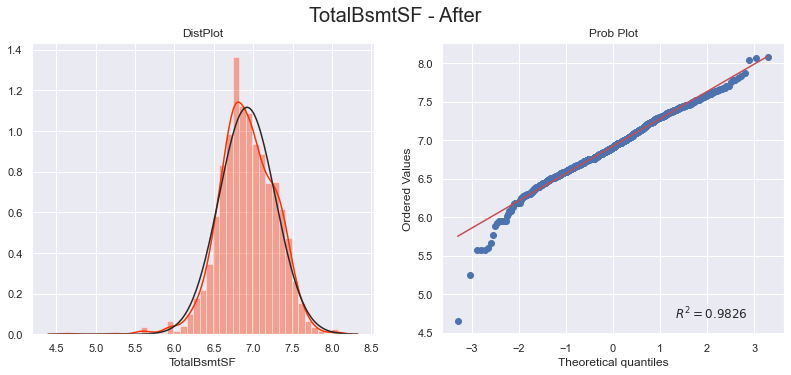

In [15]:
plt.figure(figsize=(12,5))
plt.suptitle('TotalBsmtSF - After', fontsize=20)

plt.subplot(121)
sns.distplot(df[df.TotalBsmtSF >0]['TotalBsmtSF'], fit=norm);
plt.title('DistPlot')

plt.subplot(122)
stats.probplot(df[df.TotalBsmtSF >0]['TotalBsmtSF'], plot=plt,rvalue=True)
plt.title('Prob Plot')



## Usually normalizing the data would correct Homoscedasticity issue. Lets see

Text(0.5, 1.0, 'After log')

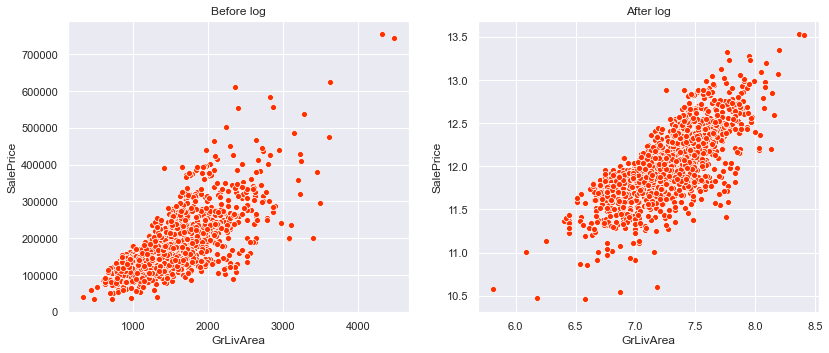

In [16]:
plt.figure(figsize=(12,5))

sns.set_style('darkgrid')
plt.subplot(121)
sns.scatterplot(d2.GrLivArea,d2.SalePrice)
plt.title('Before log')

plt.subplot(122)
sns.scatterplot(df.GrLivArea,df.SalePrice)
plt.title('After log')


Now salesprice shows equal variability acorss all values of independent values.

In [17]:
X = df[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']]
Y = df['SalePrice']

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state = 32)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


In [18]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
clf.fit(X_train,y_train)

pred = clf.predict(X_test)

print(rmsle(y_test,pred))

0.1833185524896162


In [19]:
test = pd.read_csv('test.csv')
test1 = test[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']]

test1.GarageCars = test1['GarageCars'].fillna(np.mean(test1['GarageCars']))
test1['TotalBsmtSF'] = test1['TotalBsmtSF'].fillna(np.mean(test1['TotalBsmtSF']))


test2 = test1.copy()
test2['GrLivArea'] = np.log(test2.GrLivArea)
test2['TotalBsmtSF'] = test2['TotalBsmtSF'].apply(lambda x : np.log(x) if x > 0 else x)


/Users/logpoint/Gaurav/Projects/virtualenv/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/logpoint/Gaurav/Projects/virtualenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [20]:
from sklearn.ensemble import GradientBoostingRegressor

clf = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5,)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)

print(rmsle(y_test,pred))

0.1799249393540027


In [21]:
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3,4,5,6,10],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }
# # Create a based model
# rf = RandomForestRegressor()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(X, Y)

# Part 2 ; trying to understand important features

In [104]:
import re

x = sorted(data.columns)
Garage_columns = [j for j in x if 'garage' in j.lower()]
Bsmt_columns = [j for j in x if 'bsmt' in j.lower()]
Yr_columns = [j for j in x if 'yr' in j.lower()]

In [113]:
def corr_heatmap(df,col_list):
    cols = col_list.copy()
    cols.append('SalePrice')
    corr_data = df[cols].corr()
    
    return sns.heatmap(corr_data,annot=True)

def pair_plot(df,col_list):
    cols = col_list.copy()
    cols.append('SalePrice')
    
    return sns.pairplot(df[cols])


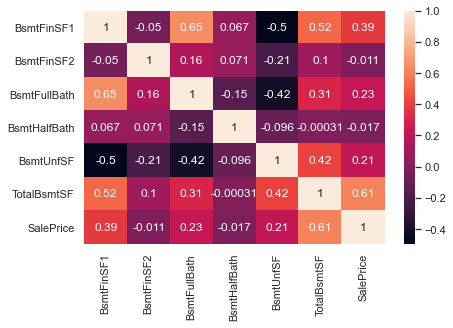

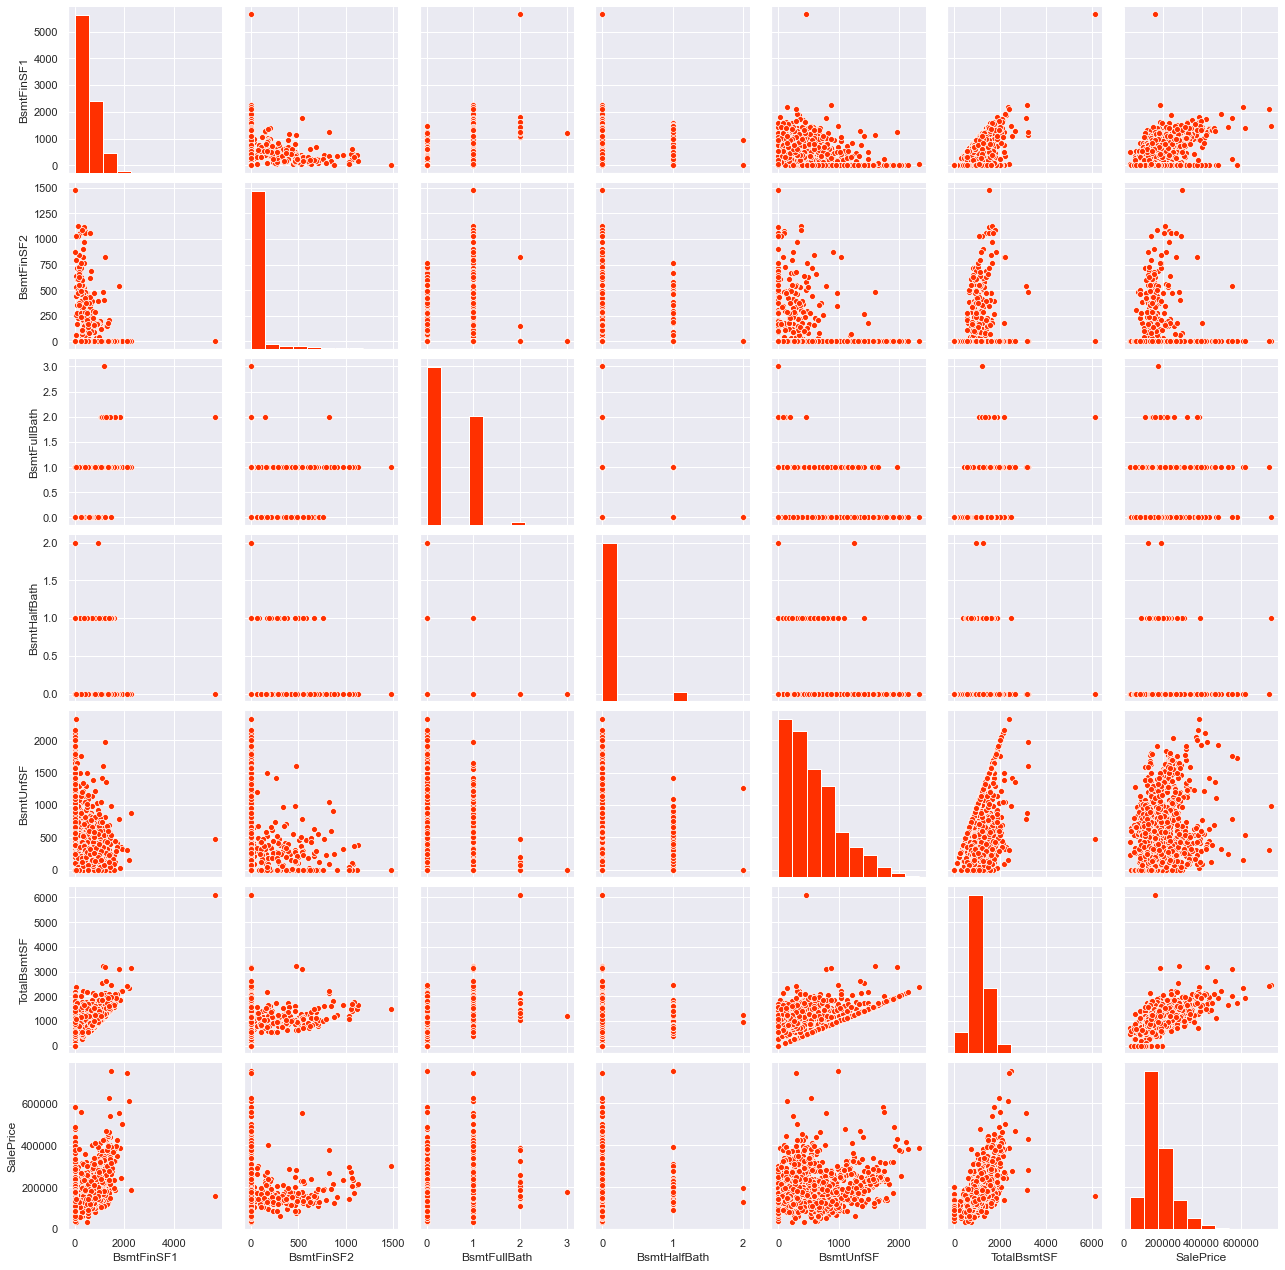

In [114]:
corr_heatmap(data,Bsmt_columns)
pair_plot(data,Bsmt_columns)

Since majority of BsmtHalfBath is 0 , lets change all non 0 values to 1. <br>
It is also a good idea to create new variables and see if they show higher correlational values.

In [118]:
data['BsmtHalfBath'] = data['BsmtHalfBath'].apply(lambda x : 0 if x == 0 else 1)

In [134]:
categorical_Bsmt_vars = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
Fin_map = {'GLQ' : 5,'ALQ' : 4,'BLQ' : 3,'Rec' : 2,'LwQ' : 1,'Unf' : 0,'NA'  : 0}
Score_map = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "None":1, "Po":0}
Ex_map = {"Gd":3, "Av":2, "Mn":1, "No":0, "None":0}

data['BsmtFinType1']  = data['BsmtFinType1'].replace(Fin_map)
data['BsmtFinType2'] = data['BsmtFinType2'].replace(Fin_map)
data['BsmtExposure'] = data['BsmtExposure'].replace(Ex_map)
data['BsmtQual'] = data['BsmtQual'].replace(Score_map)
data['BsmtCond'] = data['BsmtCond'].replace(Score_map)

#add new feature

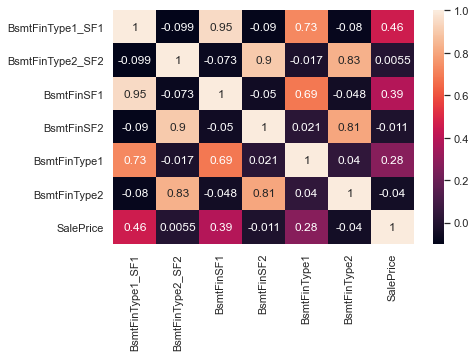

In [137]:
data['BsmtFinType1_SF1'] = data['BsmtFinSF1'] * data['BsmtFinType1']
data['BsmtFinType2_SF2'] = data['BsmtFinSF2'] * data['BsmtFinType2']

cols = ['BsmtFinType1_SF1','BsmtFinType2_SF2','BsmtFinSF1','BsmtFinSF2','BsmtFinType1','BsmtFinType2']
corr_heatmap(data,cols)

As we can see, this new variable BsmtFinType1_SF1 has high correlation to the sales than the original values.

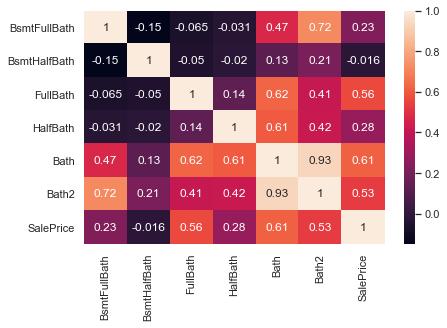

In [142]:
data['Bath']  = data['BsmtFullBath'] + data['BsmtHalfBath'] + data['FullBath'] + data['HalfBath']
data['Bath2']  = data['BsmtFullBath'] + data['BsmtHalfBath'] + (data['FullBath'] + data['HalfBath'])/2

corr_heatmap(data,['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','Bath','Bath2'])

#SO These new bath variables have higher correlation.

In [146]:
data[Garage_columns]
garage_categorical = ['GarageCond','GarageFinish','GarageQual','GarageType']
garage_numerical = ['GarageArea','GarageCars']


,GarageArea,GarageCars,GarageYrBlt
GarageArea,1.000000,0.882475,0.564567
GarageCars,0.882475,1.000000,0.588920
GarageYrBlt,0.564567,0.588920,1.000000


In [147]:
Garage_columns

['GarageArea',
 'GarageCars',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt']